1. Importing Basic Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [11]:
FILEPATH = "Microsoft_Stock.csv"
df = pd.read_csv(FILEPATH)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df.head()


,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


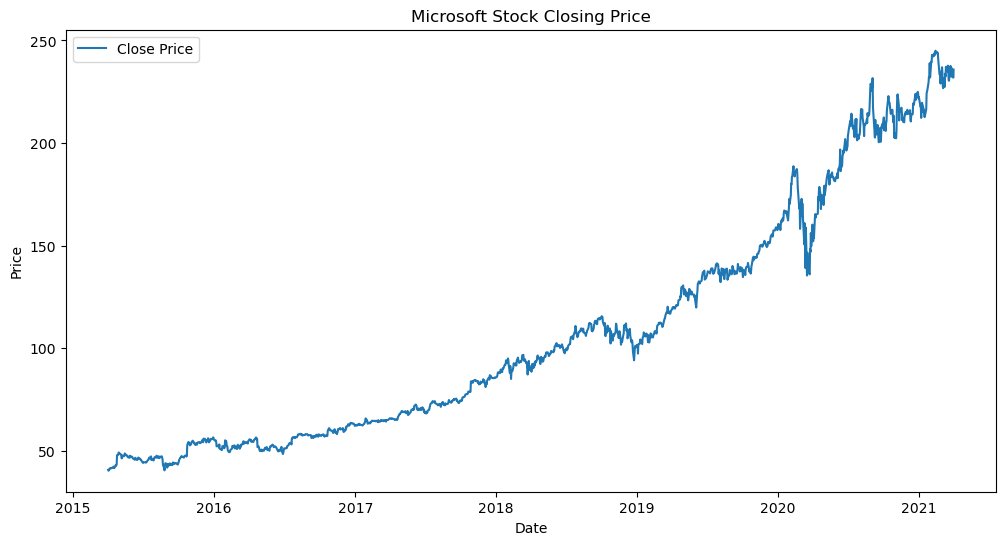

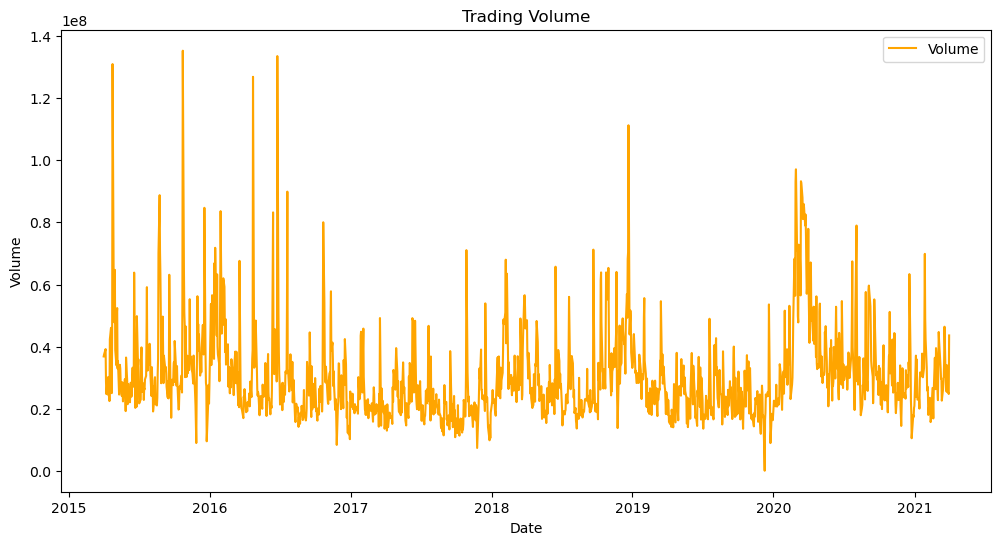

In [4]:

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title("Microsoft Stock Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Volume'], label='Volume', color='orange')
plt.title("Trading Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()


In [5]:

data = df[['Date','Close']].copy()
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data[['Close']])

# function untuk buat sequence
def create_sequences(dataset, look_back=60):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

LOOK_BACK = 60
X, y = create_sequences(scaled, LOOK_BACK)

# reshape input [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# train-test split (80-20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [6]:

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test,y_test))


C:\Users\Puri\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0060 - val_loss: 0.0075
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 8.1535e-04 - val_loss: 0.0022
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.4124e-04 - val_loss: 0.0025
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.6469e-04 - val_loss: 0.0016
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.7935e-04 - val_loss: 0.0017
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5.9282e-04 - val_loss: 0.0017
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.2681e-04 - val_loss: 0.0020
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4.2786e-04 - val_loss: 0.0019
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.3840e-04 - val_loss: 0.0016
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.9538e-04 - val_loss: 0.0016
Epoch 12/20
37/37 ━━━━━━━━━

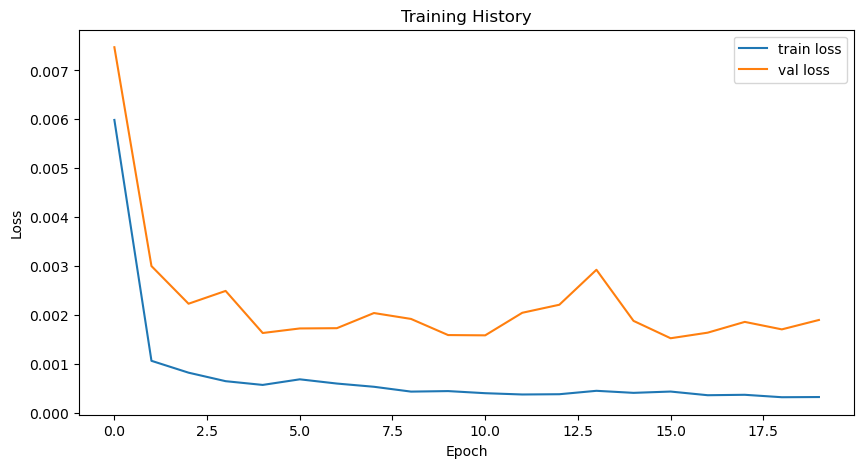

In [7]:

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step 
MSE: 79.35, RMSE: 8.91, MAE: 7.33


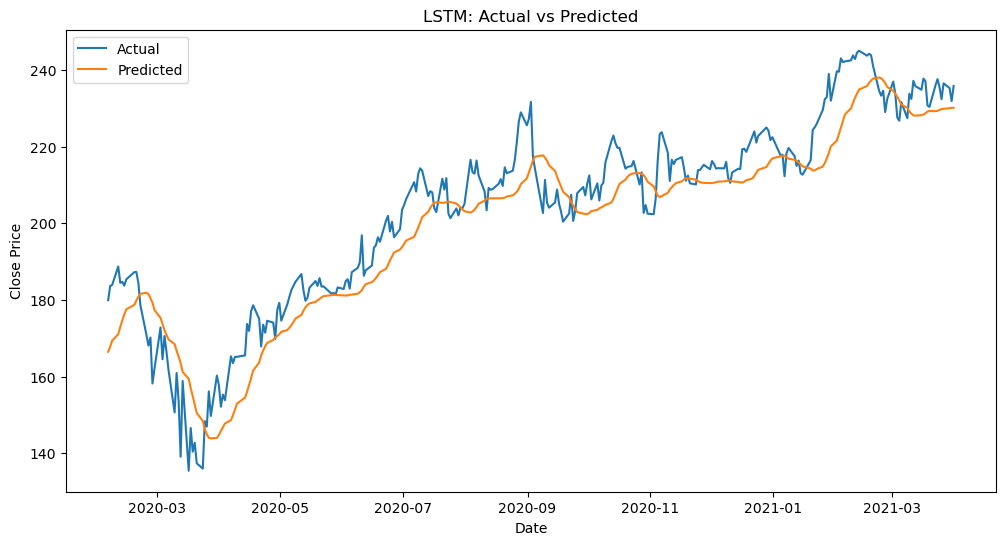

In [8]:

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(y_test_rescaled, predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, predictions)

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df['Date'][-len(y_test):], y_test_rescaled, label="Actual")
plt.plot(df['Date'][-len(y_test):], predictions, label="Predicted")
plt.title("LSTM: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

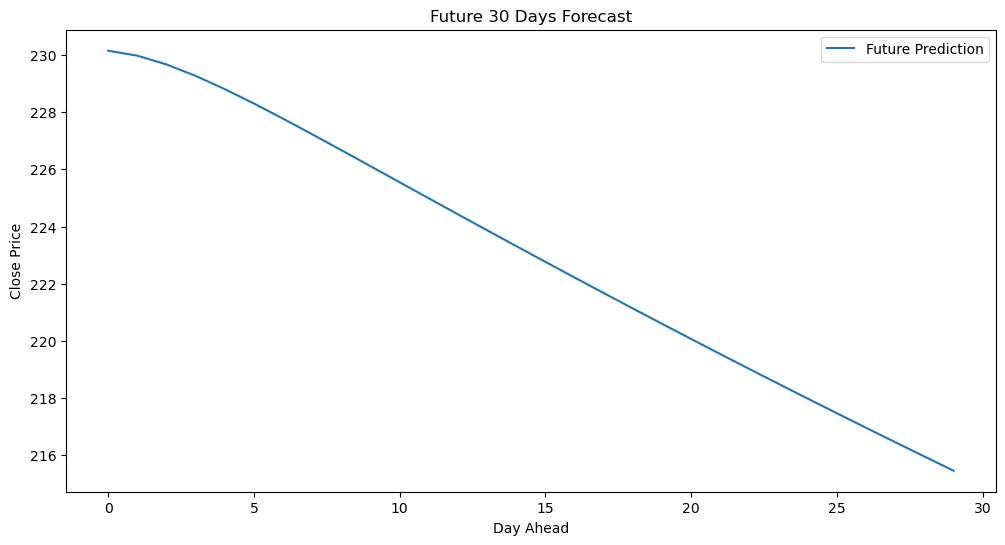

In [9]:

# Forecast next 30 days
last_sequence = scaled[-LOOK_BACK:]
future = []
curr_seq = last_sequence.reshape(1, LOOK_BACK, 1)
for _ in range(30):
    next_val = model.predict(curr_seq)[0][0]
    future.append(next_val)
    curr_seq = np.append(curr_seq[:,1:,:], [[[next_val]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future).reshape(-1,1))
plt.figure(figsize=(12,6))
plt.plot(range(len(future_prices)), future_prices, label='Future Prediction')
plt.title("Future 30 Days Forecast")
plt.xlabel("Day Ahead")
plt.ylabel("Close Price")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


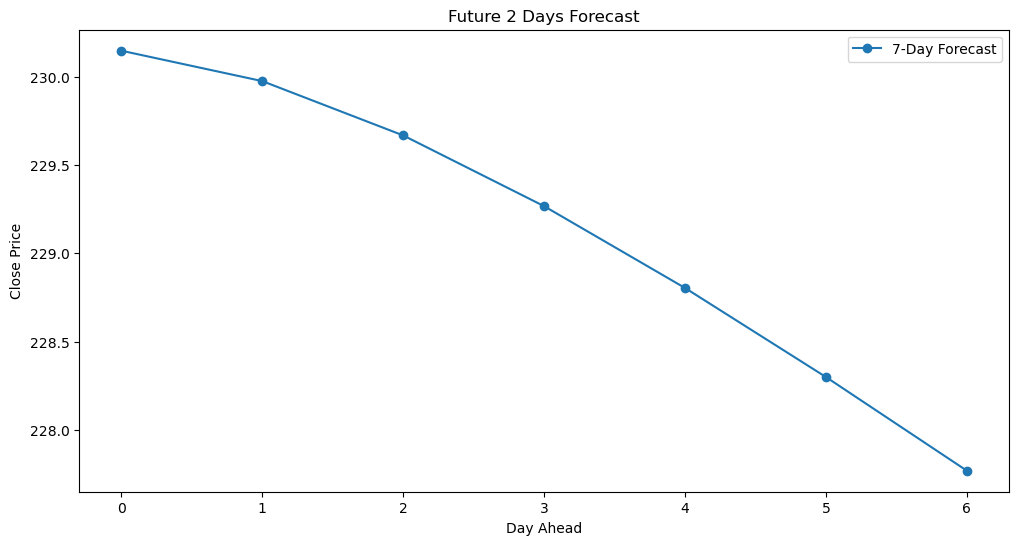

In [10]:
# Forecast next 7 days
last_sequence = scaled[-LOOK_BACK:]
future = []
curr_seq = last_sequence.reshape(1, LOOK_BACK, 1)
for _ in range(7):  # ganti 30 menjadi 7
    next_val = model.predict(curr_seq)[0][0]
    future.append(next_val)
    curr_seq = np.append(curr_seq[:,1:,:], [[[next_val]]], axis=1)

future_prices = scaler.inverse_transform(np.array(future).reshape(-1,1))

# Plot
plt.figure(figsize=(12,6))
plt.plot(range(len(future_prices)), future_prices, marker='o', label='7-Day Forecast')
plt.title("Future 2 Days Forecast")
plt.xlabel("Day Ahead")
plt.ylabel("Close Price")
plt.legend()
plt.show()
